In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Set dataset paths (adjust if your folder structure is different)
base_path = '/content/drive/MyDrive/NEU Metal Surface Defects Data'
train_dir = base_path + '/train'
val_dir = base_path + '/valid'
test_dir = base_path + '/test'


Mounted at /content/drive


In [ ]:
!pip install tensorflow keras scikit-learn seaborn


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.datasets import load_files
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import array_to_img, img_to_array, load_img


In [10]:
print("Path: ", os.listdir(base_path))
print("Train: ", os.listdir(train_dir))
print("Test: ", os.listdir(test_dir))
print("Validation: ", os.listdir(val_dir))

print("Inclusion Defect")
print("Training Images:", len(os.listdir(train_dir + '/Inclusion')))
print("Testing Images:", len(os.listdir(test_dir + '/Inclusion')))
print("Validation Images:", len(os.listdir(val_dir + '/Inclusion')))


Path:  ['train', 'test', 'valid']
Train:  ['Scratches', 'Rolled', 'Pitted', 'Patches', 'Inclusion', 'Crazing']
Test:  ['Rolled', 'Scratches', 'Patches', 'Pitted', 'Crazing', 'Inclusion']
Validation:  ['Crazing', 'Scratches', 'Inclusion', 'Rolled', 'Patches', 'Pitted']
Inclusion Defect
Training Images: 276
Testing Images: 12
Validation Images: 12


In [11]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    batch_size=10,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(200, 200),
    batch_size=10,
    class_mode='categorical')


Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


In [14]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.98:
            print("\nReached 98% accuracy, stopping training.")
            self.model.stop_training = True


In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (2, 2), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (2, 2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (2, 2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 199, 199, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 98, 98, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 49, 49, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    18,874,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,917,734 (72.17 MB)

 Trainable params: 18,917,734 (72.17 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
callbacks = myCallback()
history = model.fit(train_generator,
                    batch_size=32,
                    epochs=20,
                    validation_data=validation_generator,
                    callbacks=[callbacks],
                    verbose=1,
                    shuffle=True)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 385s 2s/step - accuracy: 0.2218 - loss: 2.6098 - val_accuracy: 0.4722 - val_loss: 1.1807
Epoch 2/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 153s 922ms/step - accuracy: 0.5230 - loss: 1.2892 - val_accuracy: 0.6944 - val_loss: 0.7258
Epoch 3/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 148s 895ms/step - accuracy: 0.6516 - loss: 0.9406 - val_accuracy: 0.7917 - val_loss: 0.5294
Epoch 4/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 151s 909ms/step - accuracy: 0.7711 - loss: 0.7039 - val_accuracy: 0.8611 - val_loss: 0.3213
Epoch 5/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 151s 909ms/step - accuracy: 0.7761 - loss: 0.6565 - val_accuracy: 0.8056 - val_loss: 0.6581
Epoch 6/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 202s 910ms/step - accuracy: 0.8265 - loss: 0.5540 - val_accuracy: 0.8472 - val_loss: 0.5356
Epoch 7/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 146s 877ms/step - accuracy: 0.8213 - loss: 0.5289 - val_accuracy: 0.9583 - val_loss: 0.1216
Epoch 8/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 203s 882ms/step - accuracy: 0.8551 - lo

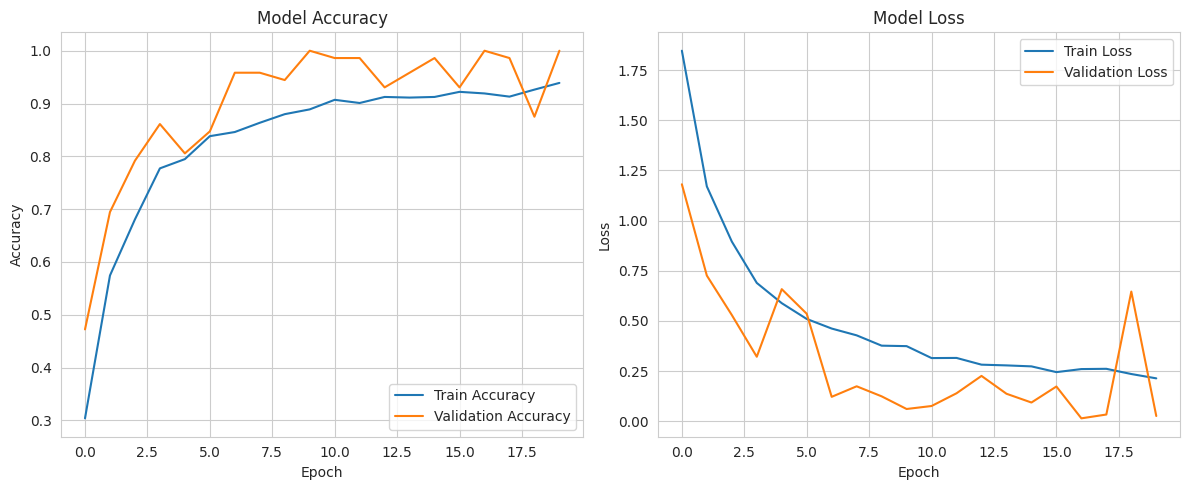

In [17]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [20]:
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files, targets, target_labels

x_test, y_test, target_labels = load_dataset(test_dir)
y_test = to_categorical(y_test, len(np.unique(y_test)))

def convert_image_to_array(files):
    images_as_array = []
    for file in files:
        images_as_array.append(img_to_array(load_img(file, target_size=(200, 200))))
    return np.array(images_as_array)

x_test = convert_image_to_array(x_test)
x_test = x_test.astype('float32') / 255


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


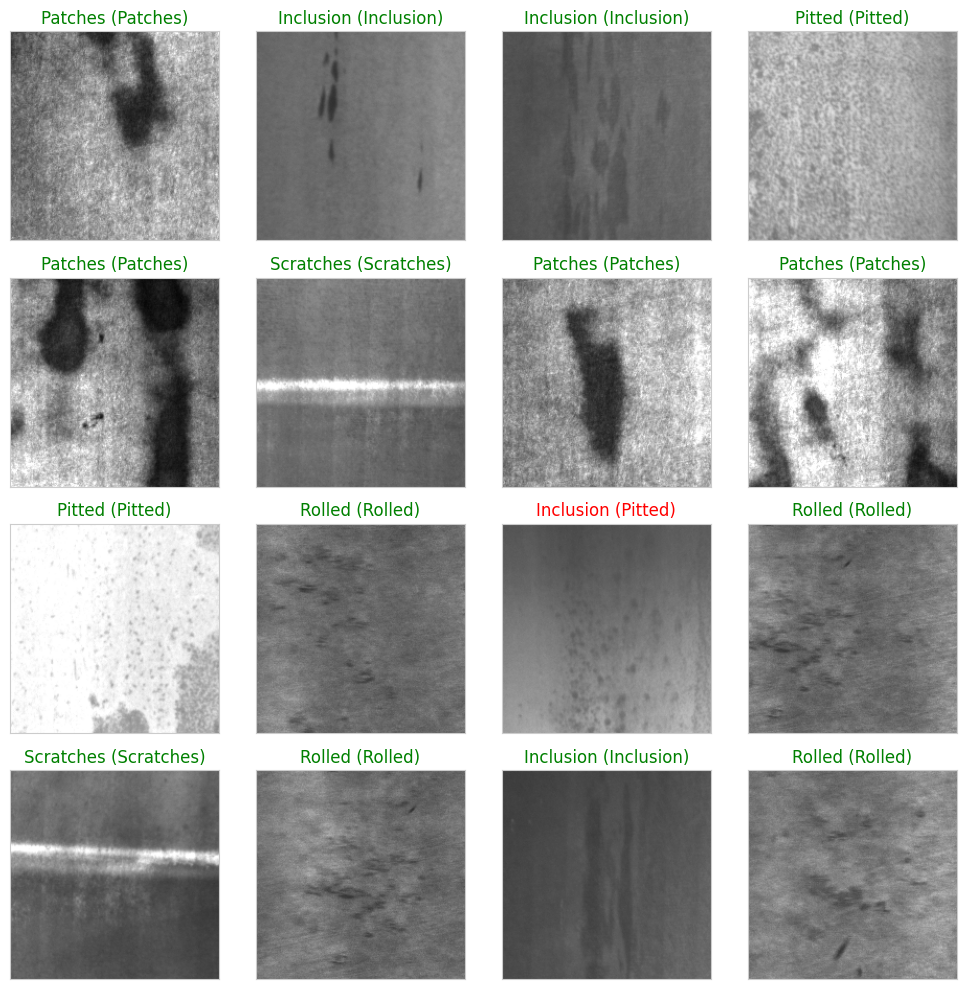

In [21]:
y_pred = model.predict(x_test)

fig = plt.figure(figsize=(10, 10))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title(f"{target_labels[pred_idx]} ({target_labels[true_idx]})",
                 color=("green" if pred_idx == true_idx else "red"))
plt.tight_layout()
plt.show()
